<a href="https://colab.research.google.com/github/yyduyuxuan/Machine-Learning-for-Data-Driven-Inventory-Replenishment-Evidence-from-the-M5-Retail-Dataset/blob/main/SP_M5_ROP_Prediction_Feature_Engineering%26Label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memory Management and Merge Strategy (from M5 solution)

**Simple "Memory profilers" to see memory usage**

A "memory visualization" mechanism has been introduced. Once a surge in RAM usage is detected, dtypes will be optimized or variables will be released proactively. - M5 2nd place solution

In [ ]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [ ]:
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2)

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [ ]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
## Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

# Importing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/'

import pandas as pd

calendar = pd.read_csv(base_path + 'calendar.csv')
sales_validation = pd.read_csv(base_path + 'sales_train_validation.csv')
sell_prices = pd.read_csv(base_path + 'sell_prices.csv')


calendar.head(20)


Mounted at /content/drive


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


In [ ]:
sales_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [ ]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# Data Preprocessing - Sales

In [ ]:
sales_validation.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.370581,1.586159,1.693670,1.248245,1.232207,1.159167,1.149000,1.328862,1.605838,1.633158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.740017,4.097191,4.359809,3.276925,3.125471,2.876026,2.950364,3.358012,4.089422,3.812248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,129.000000,160.000000,204.000000,98.000000,100.000000,88.000000,77.000000,141.000000,171.000000,130.000000


In [ ]:
#Check the types of the data
sales_validation.dtypes

,0
id,object
item_id,object
dept_id,object
cat_id,object
store_id,object
...,...
d_1909,int64
d_1910,int64
d_1911,int64
d_1912,int64


In [ ]:
# Missing Value?
print(sales_validation.isnull().sum())

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64


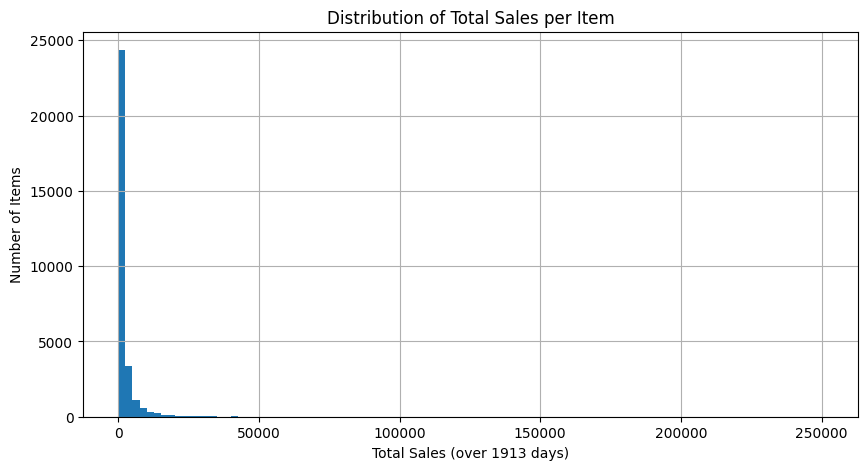

In [ ]:
import matplotlib.pyplot as plt

# Calculate total sales for each item
total_sales = sales_validation.iloc[:, 6:].sum(axis=1)

plt.figure(figsize=(10, 5))
plt.hist(total_sales, bins=100)
plt.title("Distribution of Total Sales per Item")
plt.xlabel("Total Sales (over 1913 days)")
plt.ylabel("Number of Items")
plt.grid(True)
plt.show()

• Almost all products are clustered on the left, indicating that the total sales volume is very low

• There are very few products with high total sales volume (there is a long tail on the right)

• A small number of "hot products" contribute to most of the sales

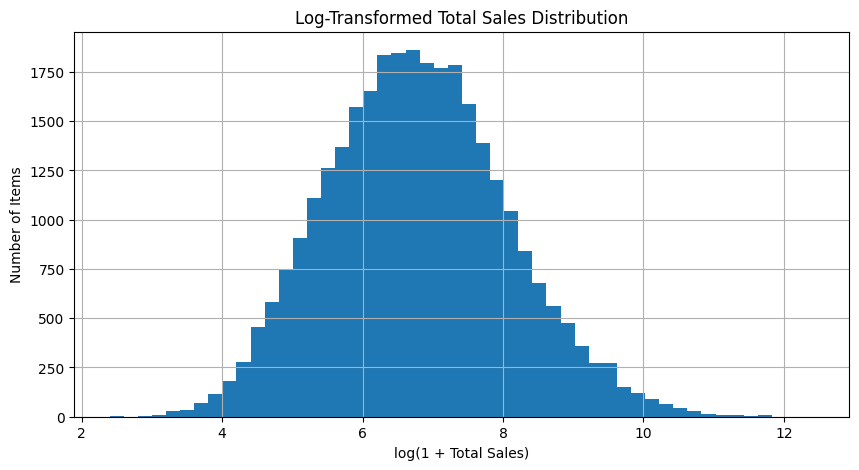

In [ ]:
import numpy as np

plt.figure(figsize=(10,5))
plt.hist(np.log1p(total_sales), bins=50)
plt.title("Log-Transformed Total Sales Distribution")
plt.xlabel("log(1 + Total Sales)")
plt.ylabel("Number of Items")
plt.grid(True)
plt.show()

The peak is around log ≈ 6.5

• This means that the total sales of most products are about:
exp(6.5) - 1 ≈ 665 units (in five years)

• Therefore: the cumulative sales of most products in five years are between 600 and 700

## Supplementary
**Product life cycle management**

In this preprocessing step, we filter the sales data to retain only items with a sufficiently long sales history and consistent activity. Specifically, we keep items that have:

	•	A product lifecycle of at least 180 days, and
	•	Been actively sold on at least 30 different days during their lifecycle.

This filtering ensures that the model is trained on items with meaningful sales patterns and enough historical data to support reliable feature extraction (e.g., lag features, rolling statistics, intermittency measures). Items with extremely short lifecycles or highly sporadic sales may not provide enough signal for forecasting or inventory-related decision-making (Makridakis et al., 2022; Petropoulos et al., 2022).

By focusing on consistently active items, we aim to improve the robustness and stability of downstream machine learning models while reducing noise from infrequent or discontinued products. This approach is in line with best practices in time-series forecasting competitions such as M5 (Makridakis et al., 2022), where participants commonly excluded low-activity SKUs to prioritize model generalization on core products.

In [ ]:
# Select all sales columns (column names start with 'd_')
sales_cols = [col for col in sales_validation.columns if col.startswith('d_')]
sales_data = sales_validation[sales_cols]

# Calculate the first and last column names with sales
first_sale_day = (sales_data > 0).idxmax(axis=1)
last_sale_day = (sales_data.iloc[:, ::-1] > 0).idxmax(axis=1)

# Get day number
first_sale_day_num = first_sale_day.str.replace('d_', '').astype(int)
last_sale_day_num = last_sale_day.str.replace('d_', '').astype(int)

# Calculate lifetime (last non-zero - first non-zero + 1)
lifecycle_days = last_sale_day_num - first_sale_day_num + 1

# Calculate the number of days with sales
active_days = (sales_data > 0).sum(axis=1)

sales_validation['lifecycle_days'] = lifecycle_days
sales_validation['active_days'] = active_days

# Filter conditions (here we take life cycle >= 180 days and active days >= 30 days as an example)
filtered_sales = sales_validation[(sales_validation['lifecycle_days'] >= 180) & (sales_validation['active_days'] >= 30)]

# Print out results
print(f"Filtered items: {filtered_sales.shape[0]} / Original items: {sales_validation.shape[0]}")

filtered_sales.head()

Filtered items: 30379 / Original items: 30490


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,lifecycle_days,active_days
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,1,1,3,0,1,1,1012,421
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,1,0,0,0,0,1766,402
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,1,0,1,1,1,808,216
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,5,4,1,0,1,3,7,2,1877,1296
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,1,1,2,2,2,4,1801,963


In [ ]:
sales_validation = filtered_sales.copy()

# Data Preprocessing - Calendar

In [ ]:
calendar.describe()

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


In [ ]:
calendar.dtypes

,0
date,object
wm_yr_wk,int64
weekday,object
wday,int64
month,int64
year,int64
d,object
event_name_1,object
event_type_1,object
event_name_2,object


In [ ]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar.dtypes

,0
date,datetime64[ns]
wm_yr_wk,int64
weekday,object
wday,int64
month,int64
year,int64
d,object
event_name_1,object
event_type_1,object
event_name_2,object


In [ ]:
print(calendar.isnull().sum())

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64


In [ ]:
# Fill null
event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
calendar[event_cols] = calendar[event_cols].fillna('None')
print(calendar.isnull().sum())

date            0
wm_yr_wk        0
weekday         0
wday            0
month           0
year            0
d               0
event_name_1    0
event_type_1    0
event_name_2    0
event_type_2    0
snap_CA         0
snap_TX         0
snap_WI         0
dtype: int64


In [ ]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1


Calendar-based categorical features, such as event_name_1 and event_type_1, are transformed into one-hot encoded dummy variables using pd.get_dummies. Missing values are first replaced with a placeholder “None”. We retain all dummy variables (drop_first=False) as we employ tree-based models like LightGBM that are not susceptible to multicollinearity issues and benefit from full category representation.

# Data Preprocessing - Price

In [ ]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [ ]:
sell_prices.dtypes

,0
store_id,object
item_id,object
wm_yr_wk,int64
sell_price,float64


In [ ]:
print(sell_prices.isnull().sum())
print((sell_prices['sell_price'] <= 0).sum())

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64
0


In [ ]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# Overview of the data

In [ ]:
from IPython.display import Markdown

markdown_table = """
| VARIABLE NAME | DESCRIPTION | DATA TYPE | SOURCE TABLE |
|---------------|-------------|-----------|---------------|
| id | unique identifier for item + store | object | sales_validation |
| item_id | ID of the item (product) | object | sales_validation |
| dept_id | department the item belongs to | object | sales_validation |
| cat_id | category of the item (FOODS, etc.) | object | sales_validation |
| store_id | store ID where the item is sold | object | sales_validation |
| state_id | state corresponding to store | object	 | sales_validation |
| d_1 ~ d_1913 | daily unit sales over time | int64 | sales_validation |
| date | calendar date | datetime64[ns] | calendar |
| wm_yr_wk | unique week ID for joining prices | int64 | calendar |
| weekday | day of the week (e.g., Saturday) | object | calendar |
| wday | numeric day of the week (1-7) | int64 | calendar |
| month | month number (1-12) | int64 | calendar |
| year | year (2011–2016) | int64 | calendar |
| d | label matching d_1 ~ d_1913 | object | calendar |
| event_name_1 | name of first public event (if any) | object | calendar |
| event_type_1 | type of first event | object | calendar |
| event_name_2 | name of second public event | object | calendar |
| event_type_2 | type of second event | object | calendar |
| snap_CA | SNAP active in CA (1 = yes) | int64 | calendar |
| snap_TX | SNAP active in TX | int64 | calendar |
| snap_WI | SNAP active in WI | int64 | calendar |
| store_id | store where item is sold | object | sell_prices |
| item_id | product ID | object | sell_prices |
| wm_yr_wk | join key to calendar week | int64 | sell_prices |
| sell_price | unit selling price (USD) | float64 | sell_prices |
"""

display(Markdown(markdown_table))


| VARIABLE NAME | DESCRIPTION | DATA TYPE | SOURCE TABLE |
|---------------|-------------|-----------|---------------|
| id | unique identifier for item + store | object | sales_validation |
| item_id | ID of the item (product) | object | sales_validation |
| dept_id | department the item belongs to | object | sales_validation |
| cat_id | category of the item (FOODS, etc.) | object | sales_validation |
| store_id | store ID where the item is sold | object | sales_validation |
| state_id | state corresponding to store | object	 | sales_validation |
| d_1 ~ d_1913 | daily unit sales over time | int64 | sales_validation |
| date | calendar date | datetime64[ns] | calendar |
| wm_yr_wk | unique week ID for joining prices | int64 | calendar |
| weekday | day of the week (e.g., Saturday) | object | calendar |
| wday | numeric day of the week (1-7) | int64 | calendar |
| month | month number (1-12) | int64 | calendar |
| year | year (2011–2016) | int64 | calendar |
| d | label matching d_1 ~ d_1913 | object | calendar |
| event_name_1 | name of first public event (if any) | object | calendar |
| event_type_1 | type of first event | object | calendar |
| event_name_2 | name of second public event | object | calendar |
| event_type_2 | type of second event | object | calendar |
| snap_CA | SNAP active in CA (1 = yes) | int64 | calendar |
| snap_TX | SNAP active in TX | int64 | calendar |
| snap_WI | SNAP active in WI | int64 | calendar |
| store_id | store where item is sold | object | sell_prices |
| item_id | product ID | object | sell_prices |
| wm_yr_wk | join key to calendar week | int64 | sell_prices |
| sell_price | unit selling price (USD) | float64 | sell_prices |


# Table Merging and Overall Data Processing

In [ ]:
calendar = reduce_mem_usage(calendar)
calendar['date'] = pd.to_datetime(calendar['date'])

Mem. usage decreased to  0.12 Mb (41.9% reduction)


In [ ]:
import pandas as pd

value_vars = [col for col in sales_validation.columns if col.startswith('d_')]

sales_long_val = pd.melt(sales_validation,
                     id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                     value_vars=value_vars,
                     var_name='d',
                     value_name='sales')

calendar = pd.read_csv(base_path + 'calendar.csv')
calendar['date'] = pd.to_datetime(calendar['date']) # datetime

sales_long_val = merge_by_concat(
    sales_long_val,
    calendar[['d', 'date']],
    merge_on=['d']
)
sales_long_val.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date
58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1,2016-04-24
58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24
58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3,2016-04-24
58327369,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24


In [ ]:
import pandas as pd
import numpy as np

s = sales_long_val['sales'].astype(float)

desc = pd.DataFrame({
    'mean': [s.mean()],
    'std': [s.std(ddof=1)],
    'min': [s.min()],
    'p25': [s.quantile(0.25)],
    'p50_median': [s.median()],
    'p75': [s.quantile(0.75)],
    'max': [s.max()],
    'n_obs': [s.size]
}).round(2)

desc

,mean,std,min,p25,p50_median,p75,max,n_obs
0,1.13,3.87,0.0,0.0,0.0,1.0,763.0,58327370


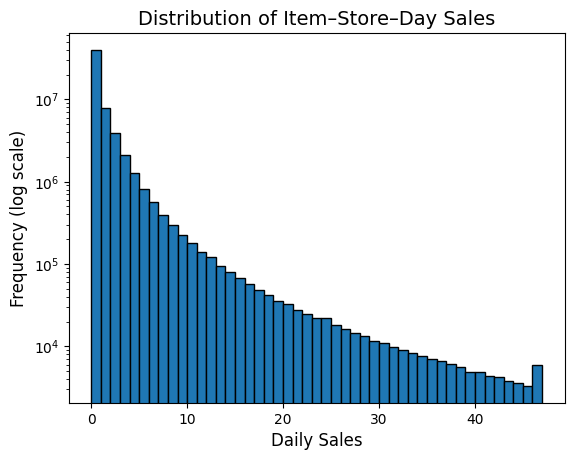

In [ ]:
max_sales = int(df_plot['sales'].max())
plt.hist(df_plot['sales'], bins=range(0, max_sales+1),
         edgecolor='black', log=True)

plt.xlabel("Daily Sales", fontsize=12)
plt.ylabel("Frequency (log scale)", fontsize=12)
plt.title("Distribution of Item–Store–Day Sales", fontsize=14)

plt.show()

In [ ]:
print("Memory after base data merge:", get_memory_usage(), "GB")
sales_long_val = reduce_mem_usage(sales_long_val)

Memory after base data merge: 5.32 GB
Mem. usage decreased to 3671.27 Mb (8.3% reduction)


In [ ]:
# Merge calendar table
calendar_cols = [
    'd', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI'
]

calendar_subset = calendar[calendar_cols]
sales_long_val = merge_by_concat(sales_long_val, calendar_subset, merge_on=['d'])

sales_long_val.head()



,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


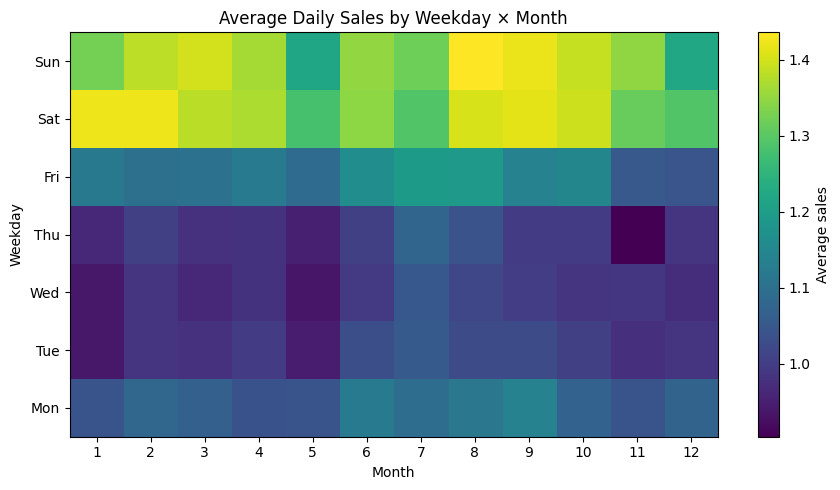

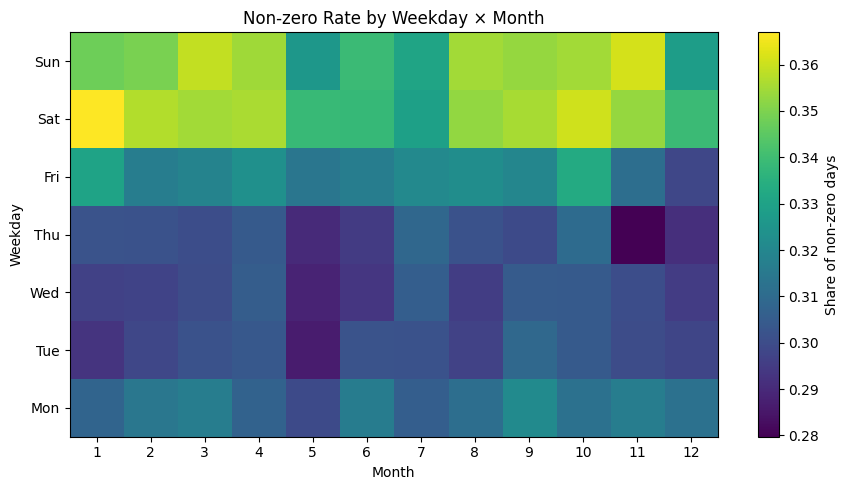

Weekend uplift vs. weekdays (average sales): 31.1%
Weekend uplift vs. weekdays (non-zero rate): 14.1%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = sales_long_val.copy()

# Sat=1, Sun=2, Mon=3, Tue=4, Wed=5, Thu=6, Fri=7
df['wday_num']  = pd.to_numeric(df['wday'], errors='coerce')
df['month_num'] = pd.to_numeric(df['month'], errors='coerce')

order_mon_to_sun = [3, 4, 5, 6, 7, 1, 2]
tick_labels_mon_to_sun = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

# Average sales heat map
pivot_mean = (
    df.groupby(['wday_num','month_num'])['sales'].mean()
      .unstack('month_num')
      .reindex(index=order_mon_to_sun, columns=range(1,13))
)

plt.figure(figsize=(9,5))
im = plt.imshow(pivot_mean.values, aspect='auto', origin='lower')
plt.title("Average Daily Sales by Weekday × Month")
plt.xlabel("Month"); plt.ylabel("Weekday")
plt.xticks(range(12), range(1,13))
plt.yticks(range(7), tick_labels_mon_to_sun)
cbar = plt.colorbar(im); cbar.set_label("Average sales")
plt.tight_layout(); plt.show()

# Non-zero rate heat map
pivot_nzr = (
    df.groupby(['wday_num','month_num'])['sales'].apply(lambda x: (x>0).mean())
      .unstack('month_num')
      .reindex(index=order_mon_to_sun, columns=range(1,13))
)

plt.figure(figsize=(9,5))
im = plt.imshow(pivot_nzr.values, aspect='auto', origin='lower')
plt.title("Non-zero Rate by Weekday × Month")
plt.xlabel("Month"); plt.ylabel("Weekday")
plt.xticks(range(12), range(1,13))
plt.yticks(range(7), tick_labels_mon_to_sun)
cbar = plt.colorbar(im); cbar.set_label("Share of non-zero days")
plt.tight_layout(); plt.show()

# Weekend uplift (note: weekend is wday=1,2)
wknd_mask = df['wday_num'].isin([1,2])     # Sat, Sun
wkdy_mask = df['wday_num'].isin([3,4,5,6,7])  # Mon–Fri

wknd_mean = df.loc[wknd_mask, 'sales'].mean()
wkdy_mean = df.loc[wkdy_mask, 'sales'].mean()
uplift_mean = (wknd_mean / wkdy_mean - 1) * 100 if wkdy_mean > 0 else np.nan

wknd_nzr = (df.loc[wknd_mask, 'sales'] > 0).mean()
wkdy_nzr = (df.loc[wkdy_mask, 'sales'] > 0).mean()
uplift_nzr = (wknd_nzr / wkdy_nzr - 1) * 100 if wkdy_nzr > 0 else np.nan

print(f"Weekend uplift vs. weekdays (average sales): {uplift_mean:.1f}%")
print(f"Weekend uplift vs. weekdays (non-zero rate): {uplift_nzr:.1f}%")

In [ ]:
print("Memory after base data merge:", get_memory_usage(), "GB")
sales_long_val = reduce_mem_usage(sales_long_val)

Memory after base data merge: 14.01 GB
Mem. usage decreased to 6396.91 Mb (29.0% reduction)


In [ ]:
# Merge price table
sales_long_val = merge_by_concat(
    sales_long_val,
    sell_prices,
    merge_on=['item_id', 'store_id', 'wm_yr_wk']
)

sales_long_val.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.98
58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.48
58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,3.98
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,1.28
58327369,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,1.00


In [ ]:
print("Memory after base data merge:", get_memory_usage(), "GB")
sales_long_val = reduce_mem_usage(sales_long_val)

Memory after base data merge: 20.69 GB
Mem. usage decreased to 6508.16 Mb (4.9% reduction)


In [ ]:
'''
# Check
def check_sales_long_val(df):
    # 1. Print overall size
    print(" Total number of rows:", len(df))

    # 2. Check primary key uniqueness
    if {'id', 'd'}.issubset(df.columns):
        duplicate_count = df.duplicated(['id', 'd']).sum()
        print(" Duplicate (id, d) combinations:", duplicate_count)
    else:
        print("⚠️ Columns 'id' and 'd' not found — cannot check primary key uniqueness.")

    # 3. Column data type distribution
    print("\n Data type distribution:")
    print(df.dtypes.value_counts())

    # 4. NaN ratio per column
    print("\n Top columns with missing values:")
    na_ratio = df.isna().mean().sort_values(ascending=False)
    print(na_ratio[na_ratio > 0.01].head(10))

    # 5. Basic distribution sanity for key columns
    print("\n Sample value counts:")
    for col in ['store_id', 'state_id', 'item_id', 'date']:
        if col in df.columns:
            print(f"\n▶ {col} value counts:")
            print(df[col].value_counts(dropna=False).head(5))

    # 6. Sample check
    print("\n Sample preview:")
    display(df.sample(5))
check_sales_long_val(sales_long_val)
'''

 Total number of rows: 58115027
 Duplicate (id, d) combinations: 0

 Data type distribution:
object            12
int8               5
int16              3
datetime64[ns]     1
float16            1
Name: count, dtype: int64

 Top columns with missing values:
event_type_2    0.997909
event_name_2    0.997909
event_type_1    0.919498
event_name_1    0.919498
sell_price      0.208902
dtype: float64

 Sample value counts:

▶ store_id value counts:
store_id
WI_1    5826998
TX_2    5825085
WI_3    5819346
CA_1    5819346
TX_3    5817433
Name: count, dtype: int64

▶ state_id value counts:
state_id
CA    23202777
TX    17458038
WI    17454212
Name: count, dtype: int64

▶ item_id value counts:
item_id
FOODS_3_827      19130
HOBBIES_1_001    19130
FOODS_3_811      19130
FOODS_3_810      19130
FOODS_3_809      19130
Name: count, dtype: int64

▶ date value counts:
date
2016-04-24    30379
2011-01-29    30379
2011-01-30    30379
2011-01-31    30379
2011-02-01    30379
Name: count, dtype: int64

 Sa

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
47141217,FOODS_2_310_WI_1_validation,FOODS_2_310,FOODS_2,FOODS,WI_1,WI,d_1552,0,2015-04-29,11513,...,4,2015,NaN,NaN,NaN,NaN,0,0,0,3.970703
30667893,HOBBIES_1_322_TX_2_validation,HOBBIES_1_322,HOBBIES_1,HOBBIES,TX_2,TX,d_1010,0,2013-11-03,11341,...,11,2013,NaN,NaN,NaN,NaN,1,1,1,3.970703
21127441,FOODS_2_086_TX_1_validation,FOODS_2_086,FOODS_2,FOODS,TX_1,TX,d_696,0,2012-12-24,11248,...,12,2012,NaN,NaN,NaN,NaN,0,0,0,2.220703
53406773,HOBBIES_2_077_CA_1_validation,HOBBIES_2_077,HOBBIES_2,HOBBIES,CA_1,CA,d_1759,0,2015-11-22,11543,...,11,2015,NaN,NaN,NaN,NaN,0,0,0,9.968750
46868336,FOODS_3_442_WI_1_validation,FOODS_3_442,FOODS_3,FOODS,WI_1,WI,d_1543,0,2015-04-20,11512,...,4,2015,NaN,NaN,NaN,NaN,0,0,0,2.480469


In [ ]:
sales_long_val = reduce_mem_usage(sales_long_val)
print("Memory after base data merge:", get_memory_usage(), "GB")

Mem. usage decreased to 6484.47 Mb (0.0% reduction)
Memory after base data merge: 22.47 GB


**Release week**

• Used to filter out product data rows before they are put on the shelves, because these are just filler 0s and have no business significance

• Helps save memory and reduce training noise

In [ ]:
print("Release week")

# Step 1: Estimate each item's first availability by store (proxy = first price week)
release_df = sell_prices.groupby(['store_id', 'item_id'])['wm_yr_wk'].min().reset_index()
release_df.rename(columns={'wm_yr_wk': 'release'}, inplace=True)

# Step 2: Prevent duplicate merges from causing column conflicts - ensure uniqueness
release_df = release_df.drop_duplicates(subset=['store_id', 'item_id'])

# Step 3: Merge release info into main data
sales_long_val = sales_long_val.merge(release_df, on=['store_id', 'item_id'], how='left')

# Step 4: Remove rows before product release week (they are just zeros and noise)
sales_long_val = sales_long_val[sales_long_val['wm_yr_wk'] >= sales_long_val['release']]
sales_long_val = sales_long_val.reset_index(drop=True)

# Step 5: Optional - compress release column to save memory
sales_long_val['release'] = (sales_long_val['release'] - sales_long_val['release'].min()).astype(np.int16)

# Step 6: Monitor memory usage
print("{:>30}: {:>8}".format("After release filtering", sizeof_fmt(sales_long_val.memory_usage(index=True).sum())))

Release week
       After release filtering:   5.1GiB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_cleaned.pkl'
sales_long_val.to_pickle(save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print('Size:', sales_long_val.shape)

Size: (45974682, 23)


# Feature Engineering

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_cleaned.pkl'

sales_long_val = pd.read_pickle(file_path)

print(sales_long_val.shape)
sales_long_val.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(45974682, 23)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,release
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,0.459961,0
1,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,1.559570,0
2,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,3.169922,0
3,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,5.980469,0
4,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,d_1,4,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,0.700195,0


In [ ]:
print(sales_long_val.columns.tolist())

['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'release']


In [ ]:
# Data Dictionary
import pandas as pd
from IPython.display import display, HTML

# 1) columns to show
cols_order = [
    'id','item_id','dept_id','cat_id','store_id','state_id',
    'sales','date','wm_yr_wk','weekday','wday','month','year','d',
    'event_name_1','event_type_1','event_name_2','event_type_2',
    'snap_CA','snap_TX','snap_WI','sell_price','release'
]

# 2) descriptions
desc = {
    "id": "unique identifier for item + store",
    "item_id": "ID of the item (product)",
    "dept_id": "department the item belongs to",
    "cat_id": "category of the item (e.g., FOODS/HOBBIES/HOUSEHOLD)",
    "store_id": "store ID where the item is sold",
    "state_id": "state corresponding to store (CA/TX/WI)",
    "sales": "daily unit sales at the item–store–day level",
    "date": "calendar date (daily granularity)",
    "wm_yr_wk": "Walmart year–week code for joining prices",
    "weekday": "day of the week (e.g., Saturday)",
    "wday": "numeric weekday code (Sat=1 … Fri=7 in M5)",
    "month": "month number (1–12)",
    "year": "year (2011–2016)",
    "d": "daily label (d_1 … d_1913) matching calendar",
    "event_name_1": "name of first public event (if any)",
    "event_type_1": "type of first event (Sporting/Cultural/National/Religious)",
    "event_name_2": "name of second public event (if any)",
    "event_type_2": "type of second event",
    "snap_CA": "SNAP active in CA (1=yes, 0=no)",
    "snap_TX": "SNAP active in TX (1=yes, 0=no)",
    "snap_WI": "SNAP active in WI (1=yes, 0=no)",
    "sell_price": "weekly unit price at store–item level (USD)",
    "release": "first availability week per store–item (from first observed price)"
}

# 3) source tables
source = {
    "id":"sales_validation","item_id":"sales_validation","dept_id":"sales_validation",
    "cat_id":"sales_validation","store_id":"sales_validation","state_id":"sales_validation",
    "sales":"sales_validation",
    "date":"calendar","wm_yr_wk":"calendar","weekday":"calendar","wday":"calendar",
    "month":"calendar","year":"calendar","d":"calendar",
    "event_name_1":"calendar","event_type_1":"calendar",
    "event_name_2":"calendar","event_type_2":"calendar",
    "snap_CA":"calendar","snap_TX":"calendar","snap_WI":"calendar",
    "sell_price":"sell_prices","release":"sell_prices"
}

# 4) build table (use your DF name below)
df = sales_long_val
present = [c for c in cols_order if c in df.columns]

data_dict = pd.DataFrame({
    "VARIABLE NAME": present,
    "DESCRIPTION": [desc.get(c, "") for c in present],
    "DATA TYPE": [str(df[c].dtype) for c in present],
    "SOURCE TABLE": [source.get(c, "") for c in present],
}).reset_index(drop=True)

# 5) style
styles = [
    dict(selector="th", props=[("text-align","left"), ("font-weight","600"), ("padding","6px 8px")]),
    dict(selector="td", props=[("text-align","left"), ("padding","6px 8px")]),
    dict(selector="tbody tr:nth-child(even)", props=[("background-color","#fafafa")]),
    dict(selector="tbody tr:hover", props=[("background-color","#f2f7ff")]),
]
styled = (
    data_dict.style
    .set_table_styles(styles)
    .set_properties(subset=["VARIABLE NAME"], **{"font-weight":"600"})
    .set_properties(**{"white-space":"nowrap"})
)

display(HTML("<h3>Data Dictionary</h3>"))
display(styled)



,VARIABLE NAME,DESCRIPTION,DATA TYPE,SOURCE TABLE
0,id,unique identifier for item + store,object,sales_validation
1,item_id,ID of the item (product),object,sales_validation
2,dept_id,department the item belongs to,object,sales_validation
3,cat_id,"category of the item (e.g., FOODS/HOBBIES/HOUSEHOLD)",object,sales_validation
4,store_id,store ID where the item is sold,object,sales_validation
5,state_id,state corresponding to store (CA/TX/WI),object,sales_validation
6,sales,daily unit sales at the item–store–day level,int16,sales_validation
7,date,calendar date (daily granularity),datetime64[ns],calendar
8,wm_yr_wk,Walmart year–week code for joining prices,int16,calendar
9,weekday,"day of the week (e.g., Saturday)",object,calendar


**Demand lag**

Lag values of past 1, 7, 14, 28 days’ sales (e.g., lag_1d, lag_7d, lag_14d, lag_28d)

In [ ]:
def add_lag_features(df, lags=[1, 7, 14, 28], group_keys=['item_id', 'store_id']):
    """
    Add lagged sales features to df (lag_1, lag_7, lag_14, lag_28)
    Sort by date and lag within each group_keys combination
    """
    df = df.sort_values(by=group_keys + ['date'])
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby(group_keys)['sales'].shift(lag)
    return df

In [ ]:
sales_long_val = add_lag_features(sales_long_val)
sales_long_val[['item_id', 'store_id', 'date', 'sales', 'lag_1', 'lag_7']].tail(20)


,item_id,store_id,date,sales,lag_1,lag_7
45396043,HOUSEHOLD_2_516,WI_3,2016-04-05,0,0.0,0.0
45426422,HOUSEHOLD_2_516,WI_3,2016-04-06,0,0.0,0.0
45456801,HOUSEHOLD_2_516,WI_3,2016-04-07,0,0.0,0.0
45487180,HOUSEHOLD_2_516,WI_3,2016-04-08,0,0.0,0.0
45517559,HOUSEHOLD_2_516,WI_3,2016-04-09,0,0.0,0.0
45547938,HOUSEHOLD_2_516,WI_3,2016-04-10,0,0.0,0.0
45578317,HOUSEHOLD_2_516,WI_3,2016-04-11,0,0.0,0.0
45608696,HOUSEHOLD_2_516,WI_3,2016-04-12,0,0.0,0.0
45639075,HOUSEHOLD_2_516,WI_3,2016-04-13,0,0.0,0.0
45669454,HOUSEHOLD_2_516,WI_3,2016-04-14,0,0.0,0.0


In [ ]:
def add_champion_lag_features(df, lags=range(28, 43), group_keys=['item_id', 'store_id']):
    """
    Add lagged sales features used by champion team (lag_28 to lag_42).
    """
    df = df.sort_values(by=group_keys + ['date'])
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby(group_keys)['sales'].shift(lag)
    return df

sales_long_val = add_champion_lag_features(sales_long_val)

In [ ]:
sales_long_val.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42
45974677,HOUSEHOLD_2_516_WI_3_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1909,0,2016-04-20,11612,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45974678,HOUSEHOLD_2_516_WI_3_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1910,0,2016-04-21,11612,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
45974679,HOUSEHOLD_2_516_WI_3_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1911,0,2016-04-22,11612,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
45974680,HOUSEHOLD_2_516_WI_3_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1912,0,2016-04-23,11613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45974681,HOUSEHOLD_2_516_WI_3_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1913,0,2016-04-24,11613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
sales_long_val = reduce_mem_usage(sales_long_val)
print("Memory after base data merge:", get_memory_usage(), "GB")

Mem. usage decreased to 5919.06 Mb (15.1% reduction)
Memory after base data merge: 18.2 GB


In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_after_lags.pkl'

sales_long_val.to_pickle(save_path)

**Demand change pattern**

Lag difference features (e.g., lag_1d - lag_7d, lag_7d - lag_14d)

This feature captures short-term changes in sales by measuring the difference between recent lagged values (e.g., yesterday vs. last week). It helps the model detect acceleration or deceleration in demand, which is useful for identifying potential turning points such as pre-peak surges or post-peak declines.

In [ ]:
def add_lag_difference_features(df):

    df['lag_1_minus_7'] = df['lag_1'] - df['lag_7']
    df['lag_7_minus_14'] = df['lag_7'] - df['lag_14']
    df['lag_14_minus_28'] = df['lag_14'] - df['lag_28']
    return df

In [ ]:
sales_long_val = add_lag_difference_features(sales_long_val)
sales_long_val[['item_id', 'date', 'lag_1', 'lag_7', 'lag_1_minus_7']].tail(10)

,item_id,date,lag_1,lag_7,lag_1_minus_7
45699833,HOUSEHOLD_2_516,2016-04-15,0.0,0.0,0.0
45730212,HOUSEHOLD_2_516,2016-04-16,0.0,0.0,0.0
45760591,HOUSEHOLD_2_516,2016-04-17,0.0,0.0,0.0
45790970,HOUSEHOLD_2_516,2016-04-18,0.0,0.0,0.0
45821349,HOUSEHOLD_2_516,2016-04-19,0.0,0.0,0.0
45851728,HOUSEHOLD_2_516,2016-04-20,0.0,0.0,0.0
45882107,HOUSEHOLD_2_516,2016-04-21,0.0,0.0,0.0
45912486,HOUSEHOLD_2_516,2016-04-22,0.0,0.0,0.0
45942865,HOUSEHOLD_2_516,2016-04-23,0.0,0.0,0.0
45973244,HOUSEHOLD_2_516,2016-04-24,0.0,0.0,0.0


**Demand statistics**

Create leakage-safe rolling features for each (item_id, store_id) pair.

It first sorts the data by date, then:

	•	Computes fixed-shift (28-day) rolling means and standard deviations over multiple windows (7–180 days).
	•	Computes sliding-shift short-term rolling means with smaller lags (1, 7, 14 days).
  
All results are merged back to the original table and stored as rolling_* columns for modeling use.

In [ ]:
def add_champion_rolling_features(df_all):
    """
    Apply fixed and sliding window rolling features (champion strategy).
    """
    # 1. Choose columns needed to calculate rolling
    df = df_all[['item_id', 'store_id', 'date', 'sales']].copy()
    df = df.sort_values(by=['item_id', 'store_id', 'date'])

    # 2. Fixed rolling feature with shift = 28
    SHIFT_DAY = 28
    for window in [7, 14, 30, 60, 180]:
        df[f'rolling_mean_{window}'] = (
            df.groupby(['item_id', 'store_id'])['sales']
              .transform(lambda x: x.shift(SHIFT_DAY).rolling(window).mean())
              .astype('float16')
        )
        df[f'rolling_std_{window}'] = (
            df.groupby(['item_id', 'store_id'])['sales']
              .transform(lambda x: x.shift(SHIFT_DAY).rolling(window).std())
              .astype('float16')
        )

    # 3. Sliding shift rolling mean (mean only)
    for d_shift in [1, 7, 14]:
        for d_window in [7, 14, 30, 60]:
            col = f'rolling_mean_tmp_{d_shift}_{d_window}'
            df[col] = (
                df.groupby(['item_id', 'store_id'])['sales']
                  .transform(lambda x: x.shift(d_shift).rolling(d_window).mean())
                  .astype('float16')
            )

    # 4. Merge the rolling features back into the whole table
    rolling_cols = [col for col in df.columns if 'rolling' in col]
    df_all = df_all.drop(columns=[col for col in df_all.columns if 'rolling' in col], errors='ignore')
    df_all = df_all.merge(df[['item_id', 'store_id', 'date'] + rolling_cols],
                          on=['item_id', 'store_id', 'date'], how='left')

    return df_all

sales_long_val = add_champion_rolling_features(sales_long_val)

In [ ]:
rolling_cols = [col for col in sales_long_val.columns if 'rolling' in col]
print(f'New rolling columns: {rolling_cols}')
sales_long_val[rolling_cols].tail()

New rolling columns: ['rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_30', 'rolling_std_30', 'rolling_mean_60', 'rolling_std_60', 'rolling_mean_180', 'rolling_std_180', 'rolling_mean_tmp_1_7', 'rolling_mean_tmp_1_14', 'rolling_mean_tmp_1_30', 'rolling_mean_tmp_1_60', 'rolling_mean_tmp_7_7', 'rolling_mean_tmp_7_14', 'rolling_mean_tmp_7_30', 'rolling_mean_tmp_7_60', 'rolling_mean_tmp_14_7', 'rolling_mean_tmp_14_14', 'rolling_mean_tmp_14_30', 'rolling_mean_tmp_14_60']


,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_30,rolling_std_30,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,...,rolling_mean_tmp_1_30,rolling_mean_tmp_1_60,rolling_mean_tmp_7_7,rolling_mean_tmp_7_14,rolling_mean_tmp_7_30,rolling_mean_tmp_7_60,rolling_mean_tmp_14_7,rolling_mean_tmp_14_14,rolling_mean_tmp_14_30,rolling_mean_tmp_14_60
45974677,0.0,0.0,0.142822,0.363037,0.099976,0.305176,0.06665,0.251465,0.099976,0.318848,...,0.0,0.049988,0.0,0.0,0.0,0.049988,0.0,0.0,0.066650,0.049988
45974678,0.0,0.0,0.071411,0.267334,0.099976,0.305176,0.06665,0.251465,0.099976,0.318848,...,0.0,0.049988,0.0,0.0,0.0,0.049988,0.0,0.0,0.066650,0.049988
45974679,0.0,0.0,0.071411,0.267334,0.099976,0.305176,0.06665,0.251465,0.099976,0.318848,...,0.0,0.049988,0.0,0.0,0.0,0.049988,0.0,0.0,0.066650,0.049988
45974680,0.0,0.0,0.071411,0.267334,0.099976,0.305176,0.06665,0.251465,0.099976,0.318848,...,0.0,0.049988,0.0,0.0,0.0,0.049988,0.0,0.0,0.033325,0.049988
45974681,0.0,0.0,0.071411,0.267334,0.099976,0.305176,0.06665,0.251465,0.099976,0.318848,...,0.0,0.049988,0.0,0.0,0.0,0.049988,0.0,0.0,0.033325,0.049988


**ADI & CV²**

Construct ADI and CV² features with multiple window lengths for each item-store (intermittent features)

Parameters:
- df: long table containing 'sales' and 'date'
- group_keys: grouping keys, default is ['item_id', 'store_id']
- ​​windows: multiple observation windows (unit: day)

Returns:
- df with ADI_x and CV2_x features added

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_after_rolling.pkl'

sales_long_val = pd.read_pickle(file_path)

print(sales_long_val.shape)
sales_long_val.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(46844332, 36)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,lag_28,lag_1_minus_7,lag_7_minus_14,lag_14_minus_28,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28
576,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11507,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_2,0,2011-01-30,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22438,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_3,0,2011-01-31,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33369,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_4,1,2011-02-01,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44300,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_5,4,2011-02-02,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
adi_cv_input = sales_long_val[['item_id', 'store_id', 'date', 'sales']].copy()

In [ ]:
adi_cv_input = reduce_mem_usage(adi_cv_input)
print("Memory after base data merge:", get_memory_usage(), "GB")

Mem. usage decreased to 1490.73 Mb (0.0% reduction)
Memory after base data merge: 22.89 GB


In [ ]:
from numba import njit
import numpy as np

@njit
def calc_adi_cv2(sales, dates, window):
    n = len(sales)
    adi_result = np.full(n, np.nan)
    cv2_result = np.full(n, np.nan)

    for i in range(window, n):
        recent_sales = sales[i - window:i]
        recent_dates = dates[i - window:i]

        nonzero_idx = np.where(recent_sales > 0)[0]
        if len(nonzero_idx) > 1:
            # ADI
            diffs = np.diff(recent_dates[nonzero_idx])
            adi_result[i] = np.mean(diffs)

            # CV²
            s_vals = recent_sales[nonzero_idx]
            cv = np.std(s_vals) / np.mean(s_vals)
            cv2_result[i] = cv ** 2

    return adi_result, cv2_result


def add_numba_adi_cv2(df, window=30):
    df = df.sort_values(['item_id', 'store_id', 'date']).copy()
    df['ADI_' + str(window)] = np.nan
    df['CV2_' + str(window)] = np.nan

    groups = df.groupby(['item_id', 'store_id'])
    total = len(groups)

    for i, (key, group) in enumerate(groups):
        if i % 100 == 0:
            print(f'Processing {i}/{total} groups...')

        sales = np.array(group['sales'].values, dtype=np.float32)
        dates = np.array(group['date'].astype('int64') // 86400000000000, dtype=np.int64)

        adi, cv2 = calc_adi_cv2(sales, dates, window)

        df.loc[group.index, 'ADI_' + str(window)] = adi
        df.loc[group.index, 'CV2_' + str(window)] = cv2

    print('Finished ADI/CV² computation.')
    return df

In [ ]:
adi_cv_input['sales'] = adi_cv_input['sales'].astype(np.float32)
adi_cv_input['date'] = pd.to_datetime(adi_cv_input['date'])

In [ ]:
adi_cv_result_30 = add_numba_adi_cv2(adi_cv_input, window=30)
adi_cv_result_60 = add_numba_adi_cv2(adi_cv_input, window=60)
adi_cv_result_90 = add_numba_adi_cv2(adi_cv_input, window=90)

Processing 0/30379 groups...
Processing 100/30379 groups...
Processing 200/30379 groups...
Processing 300/30379 groups...
Processing 400/30379 groups...
Processing 500/30379 groups...
Processing 600/30379 groups...
Processing 700/30379 groups...
Processing 800/30379 groups...
Processing 900/30379 groups...
Processing 1000/30379 groups...
Processing 1100/30379 groups...
Processing 1200/30379 groups...
Processing 1300/30379 groups...
Processing 1400/30379 groups...
Processing 1500/30379 groups...
Processing 1600/30379 groups...
Processing 1700/30379 groups...
Processing 1800/30379 groups...
Processing 1900/30379 groups...
Processing 2000/30379 groups...
Processing 2100/30379 groups...
Processing 2200/30379 groups...
Processing 2300/30379 groups...
Processing 2400/30379 groups...
Processing 2500/30379 groups...
Processing 2600/30379 groups...
Processing 2700/30379 groups...
Processing 2800/30379 groups...
Processing 2900/30379 groups...
Processing 3000/30379 groups...
Processing 3100/3037

In [ ]:
adi_cv_result_30[['item_id', 'date', 'ADI_30', 'CV2_30']].iloc[25:35]

,item_id,date,ADI_30,CV2_30
299863,FOODS_1_001,2011-02-23,NaN,NaN
312661,FOODS_1_001,2011-02-24,NaN,NaN
325459,FOODS_1_001,2011-02-25,NaN,NaN
338263,FOODS_1_001,2011-02-26,NaN,NaN
351295,FOODS_1_001,2011-02-27,NaN,NaN
364327,FOODS_1_001,2011-02-28,1.526316,0.157382
377359,FOODS_1_001,2011-03-01,1.444444,0.163750
390391,FOODS_1_001,2011-03-02,1.473684,0.156463
403423,FOODS_1_001,2011-03-03,1.450000,0.169822
416455,FOODS_1_001,2011-03-04,1.450000,0.320700


In [ ]:
def check_adi_cv2_distribution(df, windows=[30, 60, 90]):
    summary = {}
    for window in windows:
        adi_col = f'ADI_{window}'
        cv2_col = f'CV2_{window}'
        result = {
            'ADI NaN count': df[adi_col].isna().sum(),
            'CV2 NaN count': df[cv2_col].isna().sum(),
            'ADI mean': df[adi_col].mean(),
            'CV2 mean': df[cv2_col].mean(),
            'ADI std': df[adi_col].std(),
            'CV2 std': df[cv2_col].std()
        }
        summary[f'window_{window}'] = result
    return pd.DataFrame(summary).T

In [ ]:
check_adi_cv2_distribution(adi_cv_result_90, windows=[90])

,ADI NaN count,CV2 NaN count,ADI mean,CV2 mean,ADI std,CV2 std
window_90,5550893.0,5550893.0,3.70216,0.303178,4.549378,0.284226


In [ ]:
# Merge to main table
adi_cv_result_30 = adi_cv_result_30[['item_id', 'store_id', 'date', 'ADI_30', 'CV2_30']]
adi_cv_result_60 = adi_cv_result_60[['item_id', 'store_id', 'date', 'ADI_60', 'CV2_60']]
adi_cv_result_90 = adi_cv_result_90[['item_id', 'store_id', 'date', 'ADI_90', 'CV2_90']]


adi_cv_all = adi_cv_result_30.merge(
    adi_cv_result_60, on=['item_id', 'store_id', 'date'], how='left'
).merge(
    adi_cv_result_90, on=['item_id', 'store_id', 'date'], how='left'
)


sales_long_val = sales_long_val.merge(
    adi_cv_all, on=['item_id', 'store_id', 'date'], how='left'
)

In [ ]:
sales_long_val = reduce_mem_usage(sales_long_val)
print("Memory after base data merge:", get_memory_usage(), "GB")

Mem. usage decreased to 5919.06 Mb (0.0% reduction)
Memory after base data merge: 16.39 GB


In [ ]:
print(sales_long_val[['ADI_30', 'CV2_30', 'ADI_60', 'CV2_60', 'ADI_90', 'CV2_90']].isna().sum())

ADI_30    7605210
CV2_30    7605210
ADI_60    5934766
CV2_60    5934766
ADI_90    5550893
CV2_90    5550893
dtype: int64


In [ ]:
print(sales_long_val[['ADI_30', 'ADI_60', 'ADI_90']].describe())

             ADI_30        ADI_60        ADI_90
count  3.836947e+07  4.003992e+07  4.042379e+07
mean            NaN           NaN           NaN
std    0.000000e+00  0.000000e+00  0.000000e+00
min    1.000000e+00  1.000000e+00  1.000000e+00
25%    1.333008e+00  1.415039e+00  1.450195e+00
50%    2.000000e+00  2.185547e+00  2.255859e+00
75%    3.333984e+00  3.923828e+00  4.144531e+00
max    2.900000e+01  5.900000e+01  8.900000e+01


In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_adi_cv2.pkl'
sales_long_val.to_pickle(save_path)

**Seasonality fluctuation**

Add annual seasonality features (sin/cos encoding) to df

Parameters:
- df: long table with date column
- date_col: date field name

Returns:
- df with added sin_doy and cos_doy columns

In [ ]:
import numpy as np

def add_seasonality_features(df, date_col='date'):

    df = df.copy()
    df['day_of_year'] = df[date_col].dt.dayofyear
    df['sin_doy'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['cos_doy'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    return df


sales_long_val = add_seasonality_features(sales_long_val)

# Test: Based on the existing sales_subset (containing only 100 item-stores)

# sales_subset = add_seasonality_features(sales_subset)

sales_long_val[['item_id', 'date', 'day_of_year', 'sin_doy', 'cos_doy']].head()

,item_id,date,day_of_year,sin_doy,cos_doy
0,FOODS_1_001,2011-01-29,29,0.478734,0.877960
1,FOODS_1_001,2011-01-30,30,0.493776,0.869589
2,FOODS_1_001,2011-01-31,31,0.508671,0.860961
3,FOODS_1_001,2011-02-01,32,0.523416,0.852078
4,FOODS_1_001,2011-02-02,33,0.538005,0.842942


In [ ]:
sales_long_val = reduce_mem_usage(sales_long_val)
print("Memory after base data merge:", get_memory_usage(), "GB")

Mem. usage decreased to 7146.71 Mb (0.0% reduction)
Memory after base data merge: 44.75 GB


**Time Index**

In [ ]:
def add_time_index_features(df):
    df['tm_dw'] = df['date'].dt.dayofweek.astype(np.int8)         # 0=Monday, 6=Sunday
    df['is_weekend'] = (df['tm_dw'] >= 5).astype(np.int8)         # 5=Saturday, 6=Sunday
    return df

sales_long_val = add_time_index_features(sales_long_val)
sales_long_val[['item_id', 'date', 'is_weekend']].drop_duplicates().head(10)

,item_id,date,is_weekend
0,FOODS_1_001,2011-01-29,1
1,FOODS_1_001,2011-01-30,1
2,FOODS_1_001,2011-01-31,0
3,FOODS_1_001,2011-02-01,0
4,FOODS_1_001,2011-02-02,0
5,FOODS_1_001,2011-02-03,0
6,FOODS_1_001,2011-02-04,0
7,FOODS_1_001,2011-02-05,1
8,FOODS_1_001,2011-02-06,1
9,FOODS_1_001,2011-02-07,0


In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_time_index.pkl'
sales_long_val.to_pickle(save_path)

**Calendar and event features**

Mark event fields as categorical features that LightGBM can identify

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_time_index.pkl'

sales_long_val = pd.read_pickle(file_path)

print(sales_long_val.shape)
sales_long_val.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(45974682, 51)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,CV2_90,day_of_year,sin_doy,cos_doy,tm_w,tm_m,tm_y,tm_wm,tm_dw,is_weekend
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,3,2011-01-29,11101,...,NaN,29,0.478760,0.877930,4,1,0,5,5,1
1,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2,0,2011-01-30,11101,...,NaN,30,0.493896,0.869629,4,1,0,5,6,1
2,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,2011-01-31,11101,...,NaN,31,0.508789,0.860840,5,1,0,5,0,0
3,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,1,2011-02-01,11101,...,NaN,32,0.523438,0.852051,5,2,0,1,1,0
4,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,5,4,2011-02-02,11101,...,NaN,33,0.538086,0.842773,5,2,0,1,2,0


In [ ]:
def encode_event_features(df):

    event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for col in event_cols:
        df[col] = df[col].astype('category')
    return df
# Test: Based on the existing sales_subset (containing only 100 item-stores)

# sales_subset = encode_event_features(sales_subset)

sales_long_val = encode_event_features(sales_long_val)
sales_long_val[['item_id', 'date', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']].drop_duplicates().head(10)



,item_id,date,event_name_1,event_type_1,event_name_2,event_type_2
0,FOODS_1_001,2011-01-29,NaN,NaN,NaN,NaN
1,FOODS_1_001,2011-01-30,NaN,NaN,NaN,NaN
2,FOODS_1_001,2011-01-31,NaN,NaN,NaN,NaN
3,FOODS_1_001,2011-02-01,NaN,NaN,NaN,NaN
4,FOODS_1_001,2011-02-02,NaN,NaN,NaN,NaN
5,FOODS_1_001,2011-02-03,NaN,NaN,NaN,NaN
6,FOODS_1_001,2011-02-04,NaN,NaN,NaN,NaN
7,FOODS_1_001,2011-02-05,NaN,NaN,NaN,NaN
8,FOODS_1_001,2011-02-06,SuperBowl,Sporting,NaN,NaN
9,FOODS_1_001,2011-02-07,NaN,NaN,NaN,NaN


**Price feature**

In [ ]:
sales_long_val[['item_id', 'store_id', 'date', 'wm_yr_wk', 'sell_price']].drop_duplicates().tail(10)

,item_id,store_id,date,wm_yr_wk,sell_price
45974672,HOUSEHOLD_2_516,WI_3,2016-04-15,11611,5.941406
45974673,HOUSEHOLD_2_516,WI_3,2016-04-16,11612,5.941406
45974674,HOUSEHOLD_2_516,WI_3,2016-04-17,11612,5.941406
45974675,HOUSEHOLD_2_516,WI_3,2016-04-18,11612,5.941406
45974676,HOUSEHOLD_2_516,WI_3,2016-04-19,11612,5.941406
45974677,HOUSEHOLD_2_516,WI_3,2016-04-20,11612,5.941406
45974678,HOUSEHOLD_2_516,WI_3,2016-04-21,11612,5.941406
45974679,HOUSEHOLD_2_516,WI_3,2016-04-22,11612,5.941406
45974680,HOUSEHOLD_2_516,WI_3,2016-04-23,11613,5.941406
45974681,HOUSEHOLD_2_516,WI_3,2016-04-24,11613,5.941406


**Price dynamic feature**

Add a price change flag for each item-store combination.
If the current price is different from the price 7 days ago, price_change_flag = 1, otherwise 0.

In [ ]:
def add_price_change_flag(df, group_keys=['item_id', 'store_id']):
    """
    Create a binary flag indicating whether the sell price changed compared to 7 days ago,
    while avoiding false positives due to NaN in the lag.
    """
    df = df.sort_values(by=group_keys + ['date'])

    # Calculate the price 7 days ago
    df['price_lag_7'] = df.groupby(group_keys)['sell_price'].shift(7)

    # Determine whether the price has changed (excluding NaN from the previous 7 days)
    df['price_change_flag'] = (
        df['sell_price'].ne(df['price_lag_7']) & df['price_lag_7'].notna()
    ).astype(int)

    return df

# sales_subset = add_price_change_flag(sales_subset)

sales_long_val = add_price_change_flag(sales_long_val)
sales_long_val[['item_id', 'date', 'price_lag_7', 'price_change_flag']].drop_duplicates().head(10)


,item_id,date,price_lag_7,price_change_flag
0,FOODS_1_001,2011-01-29,NaN,0
1,FOODS_1_001,2011-01-30,NaN,0
2,FOODS_1_001,2011-01-31,NaN,0
3,FOODS_1_001,2011-02-01,NaN,0
4,FOODS_1_001,2011-02-02,NaN,0
5,FOODS_1_001,2011-02-03,NaN,0
6,FOODS_1_001,2011-02-04,NaN,0
7,FOODS_1_001,2011-02-05,2.0,0
8,FOODS_1_001,2011-02-06,2.0,0
9,FOODS_1_001,2011-02-07,2.0,0


**Lifecycle feature**

is_discontinued (flag if no sales in last 90 days)

Product removal mark - Feature

To account for potential product life cycle stages, we engineered an is_discontinued binary feature that flags whether an item has been discontinued or is inactive for sale. Specifically, we define a product as “discontinued” if it has recorded zero sales over the past 90 consecutive days, inspired by similar filtering strategies in intermittent demand forecasting studies (Syntetos and Boylan, 2005; Petropoulos and Kourentzes, 2015). This feature helps capture the operational status of products, distinguishing between actively selling SKUs and items that have exited the assortment. It provides useful information for inventory planning and forecasting models to avoid overstocking or redundant predictions on obsolete items.

In practice, the threshold of 90 days can be adjusted depending on business context. Incorporating this feature as an input allows machine learning models to condition predictions based on product availability signals, following recommendations from recent forecasting research (Makridakis et al., 2022).

In [ ]:
def add_discontinued_flag(df, group_keys=['item_id', 'store_id'], window_days=90):
    """
    Add a binary flag is_discontinued: 1 if the item-store has no sales in the past 'window_days'.
    Early dates with insufficient history are marked as 0 (not discontinued).
    """
    df = df.sort_values(by=group_keys + ['date'])

    def compute_flag(group):
        rolling_sum = (
            group['sales']
            .rolling(window=window_days, min_periods=window_days)  # Output value only when window is complete
            .sum()
            .shift(1)
        )
        return (rolling_sum == 0).fillna(0)

    discontinued_mask = (
        df.groupby(group_keys, group_keys=False)
        .apply(compute_flag)
        .reset_index(drop=True)
    )

    df['is_discontinued'] = discontinued_mask.astype('int64')
    return df

# sales_subset = add_discontinued_flag(sales_subset)

sales_long_val = add_discontinued_flag(sales_long_val)
sales_long_val[['item_id', 'date', 'is_discontinued']].drop_duplicates().head(20)

,item_id,date,is_discontinued
0,FOODS_1_001,2011-01-29,0
1,FOODS_1_001,2011-01-30,0
2,FOODS_1_001,2011-01-31,0
3,FOODS_1_001,2011-02-01,0
4,FOODS_1_001,2011-02-02,0
5,FOODS_1_001,2011-02-03,0
6,FOODS_1_001,2011-02-04,0
7,FOODS_1_001,2011-02-05,0
8,FOODS_1_001,2011-02-06,0
9,FOODS_1_001,2011-02-07,0


In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_before_M5.pkl'
sales_long_val.to_pickle(save_path)

# Extra Feature Engineering from M5 Second Place

**Price**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_before M5.pkl'

sales_long_val = pd.read_pickle(file_path)

print(sales_long_val.shape)
sales_long_val.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(45974682, 54)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,cos_doy,tm_w,tm_m,tm_y,tm_wm,tm_dw,is_weekend,price_lag_7,price_change_flag,is_discontinued
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,3,2011-01-29,11101,...,0.877930,4,1,0,5,5,1,NaN,0,0
1,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2,0,2011-01-30,11101,...,0.869629,4,1,0,5,6,1,NaN,0,0
2,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,2011-01-31,11101,...,0.860840,5,1,0,5,0,0,NaN,0,0
3,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,1,2011-02-01,11101,...,0.852051,5,2,0,1,1,0,NaN,0,0
4,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,5,4,2011-02-02,11101,...,0.842773,5,2,0,1,2,0,NaN,0,0


In [ ]:
def add_price_features(prices_df, calendar_df):
    """
    Add comprehensive price-related features following M5 champion team:
    - Aggregated price stats
    - Normalized price
    - Price uniqueness
    - Price momentum
    """

    print("Generating price features...")

    # Aggregate only one row per store–item–wm_yr_wk
    prices_df = prices_df.copy()
    prices_df['price_max'] = prices_df.groupby(['store_id', 'item_id'])['sell_price'].transform('max')
    prices_df['price_min'] = prices_df.groupby(['store_id', 'item_id'])['sell_price'].transform('min')
    prices_df['price_mean'] = prices_df.groupby(['store_id', 'item_id'])['sell_price'].transform('mean')
    prices_df['price_std'] = prices_df.groupby(['store_id', 'item_id'])['sell_price'].transform('std')

    # Normalized price
    prices_df['price_norm'] = prices_df['sell_price'] / prices_df['price_max']

    # Price uniqueness
    prices_df['price_nunique'] = prices_df.groupby(['store_id', 'item_id'])['sell_price'].transform('nunique')
    prices_df['item_nunique'] = prices_df.groupby(['store_id', 'sell_price'])['item_id'].transform('nunique')

    # Merge calendar to get month/year
    calendar_info = calendar_df[['wm_yr_wk', 'month', 'year']].drop_duplicates()
    prices_df = prices_df.merge(calendar_info, on='wm_yr_wk', how='left')

    # Price momentum
    prices_df['price_momentum'] = prices_df['sell_price'] / prices_df['price_mean']
    prices_df['price_momentum_m'] = prices_df['sell_price'] / prices_df.groupby(['store_id', 'item_id', 'month'])['sell_price'].transform('mean')
    prices_df['price_momentum_y'] = prices_df['sell_price'] / prices_df.groupby(['store_id', 'item_id', 'year'])['sell_price'].transform('mean')

    # Reduce to weekly level (drop duplicates)
    prices_df = prices_df.drop_duplicates(['store_id', 'item_id', 'wm_yr_wk'])

    # Drop temp
    prices_df.drop(['month', 'year'], axis=1, inplace=True)

    return prices_df

In [ ]:
sell_prices = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Supervised Project/sell_prices.csv')
calendar_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Supervised Project/calendar.csv')

In [ ]:
prices_df = add_price_features(sell_prices, calendar_df)

Generating price features...


In [ ]:
prices_df.head()

,store_id,item_id,wm_yr_wk,sell_price,price_max,price_min,price_mean,price_std,price_norm,price_nunique,item_nunique,price_momentum,price_momentum_m,price_momentum_y
0,CA_1,HOBBIES_1_001,11325,9.58,9.58,8.26,8.285714,0.152139,1.000000,3,3,1.156207,1.131976,1.147580
1,CA_1,HOBBIES_1_001,11326,9.58,9.58,8.26,8.285714,0.152139,1.000000,3,3,1.156207,1.131976,1.147580
2,CA_1,HOBBIES_1_001,11327,8.26,9.58,8.26,8.285714,0.152139,0.862213,3,5,0.996897,0.976004,0.989459
4,CA_1,HOBBIES_1_001,11328,8.26,9.58,8.26,8.285714,0.152139,0.862213,3,5,0.996897,1.000000,0.989459
5,CA_1,HOBBIES_1_001,11329,8.26,9.58,8.26,8.285714,0.152139,0.862213,3,5,0.996897,1.000000,0.989459


In [ ]:
# Merge to sales_long_val
merge_keys = ['store_id', 'item_id', 'wm_yr_wk']
sales_long_val = merge_by_concat(sales_long_val, prices_df, merge_keys)

In [ ]:
print(sales_long_val.duplicated(subset=['item_id', 'store_id', 'date']).sum())

0


In [ ]:
sales_long_val[['item_id', 'store_id', 'sell_price', 'price_mean', 'price_momentum']].head()

,item_id,store_id,sell_price,sell_price,price_mean,price_momentum
0,FOODS_1_001,CA_1,2.0,2.0,2.169362,0.92193
1,FOODS_1_001,CA_1,2.0,2.0,2.169362,0.92193
2,FOODS_1_001,CA_1,2.0,2.0,2.169362,0.92193
3,FOODS_1_001,CA_1,2.0,2.0,2.169362,0.92193
4,FOODS_1_001,CA_1,2.0,2.0,2.169362,0.92193


In [ ]:
sales_long_val.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,price_max,price_min,price_mean,price_std,price_norm,price_nunique,item_nunique,price_momentum,price_momentum_m,price_momentum_y
45974677,HOUSEHOLD_2_516_WI_3_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1909,0,2016-04-20,11612,...,5.94,5.94,5.94,0.0,1.0,1,48,1.0,1.0,1.0
45974678,HOUSEHOLD_2_516_WI_3_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1910,0,2016-04-21,11612,...,5.94,5.94,5.94,0.0,1.0,1,48,1.0,1.0,1.0
45974679,HOUSEHOLD_2_516_WI_3_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1911,0,2016-04-22,11612,...,5.94,5.94,5.94,0.0,1.0,1,48,1.0,1.0,1.0
45974680,HOUSEHOLD_2_516_WI_3_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1912,0,2016-04-23,11613,...,5.94,5.94,5.94,0.0,1.0,1,48,1.0,1.0,1.0
45974681,HOUSEHOLD_2_516_WI_3_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1913,0,2016-04-24,11613,...,5.94,5.94,5.94,0.0,1.0,1,48,1.0,1.0,1.0


In [ ]:
'''
original_columns = list(sales_long_val.columns)
# merge
keep_columns = [col for col in sales_long_val.columns if col not in original_columns]
# Only keep the newly added price_xxx features
sales_long_val = sales_long_val[original_columns + keep_columns]
'''

In [ ]:
print("Unique dates in sales_long_val:", sales_long_val['date'].nunique())
print("Unique item-store combinations:", sales_long_val.groupby(['item_id', 'store_id']).ngroups)

Unique dates in sales_long_val: 1913
Unique item-store combinations: 30379


**Calendar**

Add calendar-related time features based on datetime-formatted 'date' column.

    Features include:
    - tm_w: week number in year
    - tm_m: month
    - tm_y: year offset (min year = 0)
    - tm_wm: week of month
    - tm_dw: day of week (0=Mon)

In [ ]:
import numpy as np
from math import ceil

def add_time_features_from_date(df):

    df['tm_w'] = df['date'].dt.isocalendar().week.astype(np.int8)  # week of year (1–52)
    df['tm_m'] = df['date'].dt.month.astype(np.int8)               # month (1–12)
    df['tm_y'] = (df['date'].dt.year - df['date'].dt.year.min()).astype(np.int8)  # year offset from min
    df['tm_wm'] = df['date'].dt.day.apply(lambda x: ceil(x / 7)).astype(np.int8)  # week-of-month
    df['tm_dw'] = df['date'].dt.dayofweek.astype(np.int8)          # day of week (0=Mon, 6=Sun)

    return df

In [ ]:
print("shape:", sales_long_val.shape)

shape: (46844332, 53)


In [ ]:
sales_long_val = add_time_features_from_date(sales_long_val)
sales_long_val[['date', 'tm_w', 'tm_m', 'tm_y', 'tm_wm', 'tm_dw']].head()

,date,tm_w,tm_m,tm_y,tm_wm,tm_dw
0,2011-01-29,4,1,0,5,5
1,2011-01-30,4,1,0,5,6
2,2011-01-31,5,1,0,5,0
3,2011-02-01,5,2,0,1,1
4,2011-02-02,5,2,0,1,2


In [ ]:
sales_long_val['d'] = sales_long_val['d'].apply(lambda x: int(x[2:])).astype(np.int16)

**Results Check**

In [ ]:
# Check
print(f"Shape: {sales_long_val.shape}")
print("Duplicate rows:", sales_long_val.duplicated(subset=['item_id', 'store_id', 'date']).sum())
print(sales_long_val.dtypes)
example = sales_long_val[(sales_long_val['item_id'] == 'FOODS_1_001') &
                         (sales_long_val['store_id'] == 'CA_1')]

print(example.sort_values('date')[['date', 'sales', 'lag_1', 'price_momentum']].head(10))

Shape: (45974682, 65)
Duplicate rows: 0
id                   object
item_id              object
dept_id              object
cat_id               object
store_id             object
                     ...   
price_nunique         int64
item_nunique          int64
price_momentum      float64
price_momentum_m    float64
price_momentum_y    float64
Length: 65, dtype: object
        date  sales  lag_1  price_momentum
0 2011-01-29      3    NaN         0.92193
1 2011-01-30      0    3.0         0.92193
2 2011-01-31      0    0.0         0.92193
3 2011-02-01      1    0.0         0.92193
4 2011-02-02      4    1.0         0.92193
5 2011-02-03      2    4.0         0.92193
6 2011-02-04      0    2.0         0.92193
7 2011-02-05      2    0.0         0.92193
8 2011-02-06      0    2.0         0.92193
9 2011-02-07      0    0.0         0.92193


In [ ]:
# Check the start and end dates for each item_id
item_date_range = sales_long_val.groupby('item_id')['date'].agg(['min', 'max'])

# Set the standard range for the full amount
expected_start = pd.Timestamp("2011-01-29")
expected_end = pd.Timestamp("2016-05-22")

# Check for non-compliant items
incomplete_items = item_date_range[
    (item_date_range['min'] > expected_start) |
    (item_date_range['max'] < expected_end)
]

print(f"Items with incomplete date coverage: {len(incomplete_items)}")
display(incomplete_items.head())

Items with incomplete date coverage: 3049


,min,max
item_id,,
FOODS_1_001,2011-01-29,2016-04-24
FOODS_1_002,2011-01-29,2016-04-24
FOODS_1_003,2011-01-29,2016-04-24
FOODS_1_004,2012-03-03,2016-04-24
FOODS_1_005,2011-01-29,2016-04-24


In [ ]:
# Calculate the number of unique item-store combinations
current_item_store_count = sales_long_val.groupby(['item_id', 'store_id']).ngroups

print(f"Unique item–store combinations in sales_long_val: {current_item_store_count}")

Unique item–store combinations in sales_long_val: 30379


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_all_feature.pkl'
sales_long_val.to_pickle(save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cross Learning Features


**Combination**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_without_encoding.pkl'

sales_long_val = pd.read_pickle(file_path)

print(sales_long_val.shape)
sales_long_val.head()

Mounted at /content/drive
(45974682, 97)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,rolling_mean_tmp_1_30,rolling_mean_tmp_1_60,rolling_mean_tmp_7_7,rolling_mean_tmp_7_14,rolling_mean_tmp_7_30,rolling_mean_tmp_7_60,rolling_mean_tmp_14_7,rolling_mean_tmp_14_14,rolling_mean_tmp_14_30,rolling_mean_tmp_14_60
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,3,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2,0,2011-01-30,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,2011-01-31,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,1,2011-02-01,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,5,4,2011-02-02,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import numpy as np
import pandas as pd

def rebuild_encodings_strict_4plus1(
    df, group_cols_list, date_col='date', target_col='sales',
    min_count=14, alpha=20
):
    out = df.copy()
    if not np.issubdtype(out[date_col].dtype, np.datetime64):
        out[date_col] = pd.to_datetime(out[date_col])

    start = out[date_col].min().normalize()
    y3_end = (start + pd.DateOffset(years=3)) - pd.Timedelta(days=1)  # train end
    y4_end = (start + pd.DateOffset(years=4)) - pd.Timedelta(days=1)  # val end
    train_mask = out[date_col] <= y3_end
    test_mask  = out[date_col] >  y4_end                               # only test for dynamic


    mu_prior = out.loc[train_mask, target_col].mean()
    sd_prior = out.loc[train_mask, target_col].std()


    drop_cols = [c for c in out.columns if c.startswith('enc_mean_') or c.startswith('enc_std_')]
    if drop_cols: out.drop(columns=drop_cols, inplace=True)

    for cols in group_cols_list:
        suf = '_'.join(cols)

        # Static (train-only), mapped to the full table
        stats = (out.loc[train_mask]
                   .groupby(cols, sort=False)[target_col]
                   .agg(mean='mean', std='std')
                   .reset_index()
                   .rename(columns={'mean': f'enc_mean_static_{suf}',
                                    'std':  f'enc_std_static_{suf}'}))
        out = out.merge(stats, on=cols, how='left')
        out[f'enc_mean_static_{suf}'] = out[f'enc_mean_static_{suf}'].fillna(mu_prior)
        out[f'enc_std_static_{suf}']  = out[f'enc_std_static_{suf}'] .fillna(sd_prior)

        # Dynamic (shift(1)+expanding) calculation in sorted copy
        tmp = out.sort_values(cols + [date_col]).copy()
        g   = tmp.groupby(cols, sort=False)
        s1  = g[target_col].shift(1)
        cnt = g.cumcount()
        ssum = s1.groupby([tmp[c] for c in cols]).cumsum()
        ssum2 = (s1**2).groupby([tmp[c] for c in cols]).cumsum()
        hmean = np.where(cnt>0, ssum/cnt, np.nan)

        mean_dyn = np.where(
            cnt < min_count,
            mu_prior,
            ((cnt*hmean) + (alpha*mu_prior)) / (cnt + alpha)
        ).astype('float32')

        var_pop = np.where(cnt>0, (ssum2/cnt) - (hmean**2), np.nan)
        with np.errstate(invalid='ignore', divide='ignore'):
            bessel = np.where(cnt>1, cnt/(cnt-1), np.nan)
        std_dyn = np.sqrt(var_pop * bessel).astype('float32')

        # Align back to original order by index
        mean_dyn_s = pd.Series(mean_dyn, index=tmp.index).reindex(out.index)
        std_dyn_s  = pd.Series(std_dyn,  index=tmp.index).reindex(out.index)

        out[f'enc_mean_{suf}'] = out[f'enc_mean_static_{suf}'].astype('float32')
        out[f'enc_std_{suf}']  = out[f'enc_std_static_{suf}'].astype('float32')
        out.loc[test_mask, f'enc_mean_{suf}'] = mean_dyn_s.loc[test_mask]
        out.loc[test_mask, f'enc_std_{suf}']  = std_dyn_s.loc[test_mask]

        out[f'enc_mean_{suf}'] = out[f'enc_mean_{suf}'].astype('float16')
        out[f'enc_std_{suf}']  = out[f'enc_std_{suf}'] .astype('float16')
        out.drop(columns=[f'enc_mean_static_{suf}', f'enc_std_static_{suf}'], inplace=True)

    print(f"[4+1 split] start={start.date()}, y3_end(train)={y3_end.date()}, y4_end(val)={y4_end.date()}, "
          f"last_date={out[date_col].max().date()}")
    return out


In [ ]:
group_cols_list = [
    ['state_id'], ['store_id'], ['cat_id'], ['dept_id'],
    ['state_id','cat_id'], ['state_id','dept_id'],
    ['store_id','cat_id'], ['store_id','dept_id'],
    ['item_id'], ['item_id','state_id'], ['item_id','store_id']
]

sales_long_val = rebuild_encodings_strict_4plus1(
    sales_long_val, group_cols_list, date_col='date', target_col='sales',
    min_count=14, alpha=20
)


[4+1 split] start=2011-01-29, y3_end(train)=2014-01-28, y4_end(val)=2015-01-28, last_date=2016-04-24


In [ ]:
sales_long_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,enc_mean_store_id_cat_id,enc_std_store_id_cat_id,enc_mean_store_id_dept_id,enc_std_store_id_dept_id,enc_mean_item_id,enc_std_item_id,enc_mean_item_id_state_id,enc_std_item_id_state_id,enc_mean_item_id_store_id,enc_std_item_id_store_id
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,3,2011-01-29,11101,...,2.75,6.753906,1.662109,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375
1,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2,0,2011-01-30,11101,...,2.75,6.753906,1.662109,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375
2,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,2011-01-31,11101,...,2.75,6.753906,1.662109,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375
3,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,1,2011-02-01,11101,...,2.75,6.753906,1.662109,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375
4,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,5,4,2011-02-02,11101,...,2.75,6.753906,1.662109,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375


In [ ]:
print(sales_long_val.columns.tolist())
print(f"Total columns: {len(sales_long_val.columns)}")

['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'release', 'lag_1', 'lag_7', 'lag_14', 'lag_28', 'lag_1_minus_7', 'lag_7_minus_14', 'lag_14_minus_28', 'ADI_30', 'CV2_30', 'ADI_60', 'CV2_60', 'ADI_90', 'CV2_90', 'day_of_year', 'sin_doy', 'cos_doy', 'tm_w', 'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'is_weekend', 'price_lag_7', 'price_change_flag', 'is_discontinued', 'price_max', 'price_min', 'price_mean', 'price_std', 'price_norm', 'price_nunique', 'item_nunique', 'price_momentum', 'price_momentum_m', 'price_momentum_y', 'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40', 'lag_41', 'lag_42', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_30', 'rolling_std_30', 'rolling_mean_60', 'rolling_std_60', '

In [ ]:
sales_long_val = sales_long_val.loc[:, ~sales_long_val.columns.duplicated()]

print("total cols:", sales_long_val.shape[1])

total cols: 119


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

pkl_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_5y.pkl'
sales_long_val.to_pickle(pkl_path)

print("Save complete")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Save complete


# Label

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_5y.pkl'

sales_long_val = pd.read_pickle(file_path)

print(sales_long_val.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(45974682, 119)


In [ ]:
import numpy as np
import pandas as pd

def recompute_forward_labels(
    df: pd.DataFrame,
    keys=('item_id','store_id'),
    date_col='date',
    sales_col='sales',
    Ls=(3,7,14),
    keep_names=('ROP_L{}','ROP_L{}')
):
    df = df.copy()

    if not np.issubdtype(df[date_col].dtype, np.datetime64):
        df[date_col] = pd.to_datetime(df[date_col])

    df = df.sort_values(list(keys) + [date_col])

    group_keys = list(keys)

    for L in Ls:
        col = keep_names[0].format(L)  # e.g., 'ROP_L3'
        df.drop(columns=[col], errors='ignore', inplace=True)
        df[col] = (
            df.groupby(group_keys, sort=False)[sales_col]
              .transform(lambda s: s.shift(-L).rolling(L, min_periods=L).sum())
        )

    return df

In [ ]:
sales_long_val = recompute_forward_labels(
    sales_long_val, keys=('item_id','store_id'), Ls=(3,7,14)
)


In [ ]:
sales_long_val.head(20)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,enc_std_store_id_dept_id,enc_mean_item_id,enc_std_item_id,enc_mean_item_id_state_id,enc_std_item_id_state_id,enc_mean_item_id_store_id,enc_std_item_id_store_id,ROP_L3,ROP_L7,ROP_L14
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,3,2011-01-29,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,NaN,NaN,NaN
1,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2,0,2011-01-30,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,NaN,NaN,NaN
2,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,2011-01-31,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,5.0,NaN,NaN
3,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,1,2011-02-01,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,7.0,NaN,NaN
4,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,5,4,2011-02-02,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,6.0,NaN,NaN
5,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,6,2,2011-02-03,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,4.0,NaN,NaN
6,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,7,0,2011-02-04,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,2.0,5.0,NaN
7,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,8,2,2011-02-05,11102,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,2.0,6.0,NaN
8,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,9,0,2011-02-06,11102,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,0.0,7.0,NaN
9,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,10,0,2011-02-07,11102,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,0.0,7.0,NaN


In [ ]:
sales_long_val.to_pickle('/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_5y_new.pkl')

In [ ]:
pkl_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_5y.pkl'
sales_long_val.to_pickle(pkl_path)

print("Save complete")

Save complete
